# Промежуточная аттестация. Распознавание ключевых точек лица в реальном времени

**Цель:** Разработать приложение, которое обнаруживает ключевые точки лица в видеопотоке в реальном времени, используя предварительно обученную модель глубокого обучения из PyTorch и OpenCV для захвата кадров и отображения видео.

**Задачи:**
- Выбрать подходящий датасет и модель.
- С помощью OpenCV, доставать кадры из видео и подготавливать их для нейронной сети. Для этого потребуется написать интерфейс, через который
можно либо подключиться к веб-камере либо загрузить видео.
- Обучить модель детекции ключевых точек лица с помощью PyTorch, убедившись, что она может эффективно работать на CPU/GPU при необходимости.
- Отрисовать обнаруженные ключевые точки лица на обработанном кадре для обратной связи с пользователем или дальнейшего анализа.

Выбран датасет с платформы [Kaggle](https://www.kaggle.com/datasets/prashantarorat/facial-key-point-data)

В качестве модели выбрана предобученная модель `keypointrcnn_resnet50_fpn`

## Импорты

In [ ]:
# Откатим версию библиотеки kaggle чтобы не было ошибки KeyError: 'username' для Colab
# !pip install kaggle==1.6.17
# !pip install facenet-pytorch # аккуратно при установке локально, сносит почти все библиотеки

In [ ]:
from zipfile import ZipFile
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
import cv2
import albumentations as A
from sklearn.metrics import mean_squared_error
from IPython.display import Video as IPVideo, display
from facenet_pytorch import MTCNN
from pathlib import Path
import subprocess
from uuid import uuid4

In [ ]:
# Зафиксируем сиды (для воспроизводимости кода)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Загрузка датасета (локально или в Colab)

In [ ]:
# Загрузим датасет (для Colab)
!kaggle datasets download -d prashantarorat/facial-key-point-data

In [ ]:
# Распакуем датасет (работает в Colab)
zip_file_path = '/content/facial-key-point-data.zip'
destination_folder = '/content/extracted_content'

try:
    with ZipFile(zip_file_path, 'r') as zip_ref:
        print(f"Extracting all files from '{zip_file_path}' to '{destination_folder}'...")
        zip_ref.extractall(destination_folder)
        print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

In [ ]:
# Список папок и файлов (в Colab)
IMAGES_DIR = "/content/extracted_content/images"
JSON_FILE  = "/content/extracted_content/all_data.json"
AUG_IMAGES_DIR = "/content/augmented_content/images"
AUG_JSON_FILE  = "/content/augmented_content/all_data_aug.json"
VAL_JSON_FILE = "/content/augmented_content/val.json"
BEST_MODEL_PATH = "best_keypoint_rcnn.pt"

In [ ]:
# # скачивание с каггл в папку cache/kagglehub локально
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("prashantarorat/facial-key-point-data")

# print("Path to dataset files:", path)

100%|██████████| 2.14G/2.14G [03:36<00:00, 10.6MB/s]

Extracting files...


Path to dataset files: C:\Users\nizae\.cache\kagglehub\datasets\prashantarorat\facial-key-point-data\versions\11


Структура папок соответствует структуре в Google Colab, для удобства работы как в Colab только локально.

In [ ]:
# # Автоопределение Colab vs локально
# try:
#     import google.colab
#     IN_COLAB = True
# except ImportError:
#     IN_COLAB = False

# # Унифицированная BASE_DIR
# BASE_DIR = Path("/content") if IN_COLAB else Path(".")

# # Пути
# EXTRACTED_DIR = BASE_DIR / "content" / "extracted_content"
# AUGMENTED_DIR = BASE_DIR / "content" / "augmented_content"

# # Переменные
# IMAGES_DIR      = EXTRACTED_DIR / "images"
# JSON_FILE       = EXTRACTED_DIR / "all_data.json"
# AUG_IMAGES_DIR  = AUGMENTED_DIR / "images"
# AUG_JSON_FILE   = AUGMENTED_DIR / "all_data_aug.json"
# VAL_JSON_FILE   = AUGMENTED_DIR / "val.json"
# BEST_MODEL_PATH = BASE_DIR / "content" / "best_keypoint_rcnn.pt"

# # Создаём директории, если работаем локально
# if not IN_COLAB:
#     for path in [IMAGES_DIR, AUG_IMAGES_DIR]:
#         path.mkdir(parents=True, exist_ok=True)

## Первичный осмотр данных

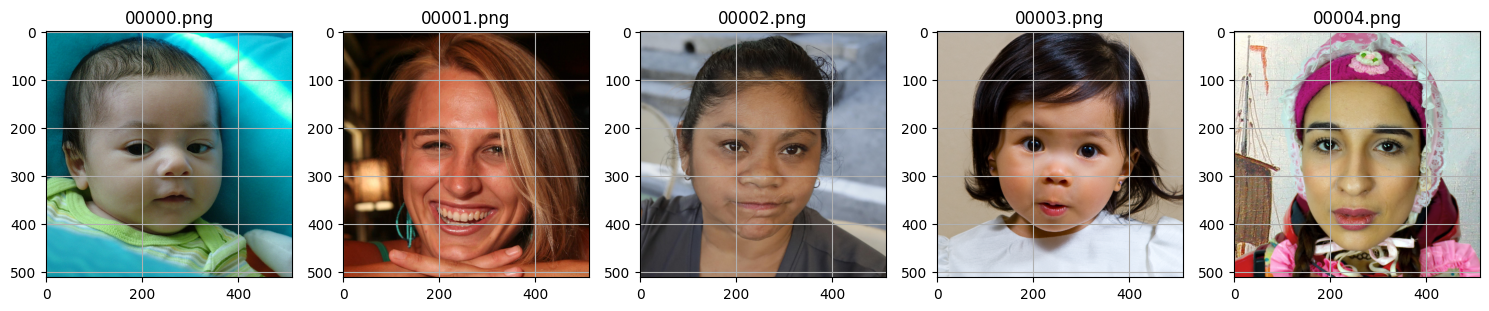

In [ ]:
# Получаем список файлов в папке
image_files = [f for f in os.listdir(IMAGES_DIR) if os.path.isfile(os.path.join(IMAGES_DIR, f))]
image_files.sort()

# Выводим первые 5 изображений
num_images_to_display = 5

plt.figure(figsize=(15, 3))  # Задаем размер фигуры для отображения нескольких изображений в ряд

for i in range(min(num_images_to_display, len(image_files))):  # Обрабатываем только первые 5 или меньше, если их меньше 5
    image_path = os.path.join(IMAGES_DIR, image_files[i])
    try:
        img = Image.open(image_path)  # Открываем изображение
        plt.subplot(1, num_images_to_display, i + 1)  # Создаем подграфик
        plt.imshow(img)  # Отображаем изображение
        plt.title(image_files[i]) # Отображаем имя файла
        # plt.axis('off')  # Отключаем оси
        plt.grid() # Сетка
    except Exception as e:
        print(f"Ошибка при открытии изображения {image_files[i]}: {e}") # Обработка ошибки, если не удалось открыть файл
        continue #Переходим к следующему файлу

plt.tight_layout()  # Автоматически корректирует параметры подграфиков для предоставления достаточного места
plt.show()

В папке images представлены лица, размер изображений 512х512, цветные в формате .png

In [ ]:
# Загрузка оригинальных аннотаций
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        return json.load(f)
orig_annotations = load_annotations(JSON_FILE)

Аннотации представляют из себя словарь такого типа:


    {'0': {'file_name': '00000.png',
      'face_landmarks': [[73.7203007518797, 237.71428571428572],
      [81.03458646616541, 276.2105263157895],
      [88.34887218045112, 312.78195488721803],
      [102.20751879699247, 347.81353383458645],
      [128.0, 375.1458646616541], ...]]


Каждой картинке из папки *images* соответствует свой список `face_landmarks` c 68 keypoints (точками) представленных в виде координат [x, y]

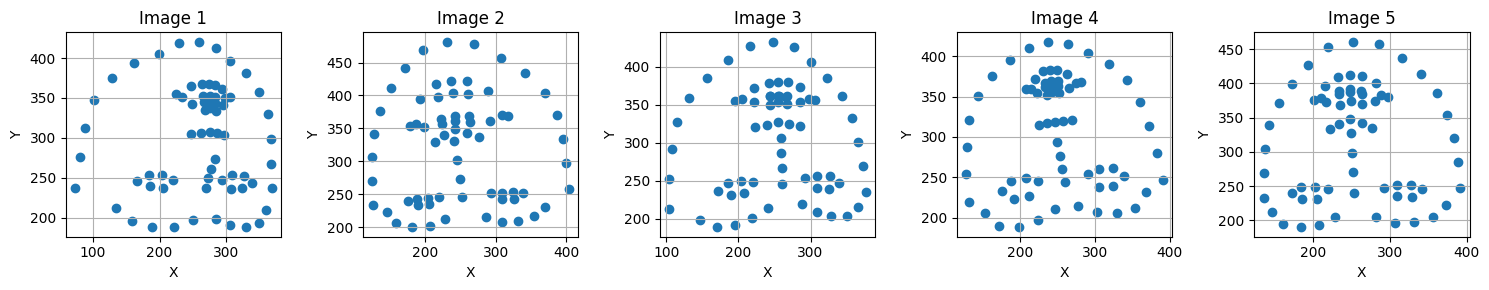

In [ ]:
# Выведем первые 5 групп точек из json файла
num_groups_to_display = 5

# Создаем figure, в которой будет сетка из подграфиков
fig, axes = plt.subplots(1, num_groups_to_display, figsize=(15, 3))  # 1 ряд, num_groups_to_display столбцов

for i in range(min(num_groups_to_display, len(orig_annotations))):
    group_key = str(i)  # Ключи в JSON - строки
    if group_key in orig_annotations:
        group_data = orig_annotations[group_key]
        face_landmarks = group_data.get('face_landmarks')

        if face_landmarks:
            x_coords = [point[0] for point in face_landmarks]
            y_coords = [point[1] for point in face_landmarks]

            # Выбираем подграфик для текущей группы
            ax = axes[i]

            ax.scatter(x_coords, y_coords)  # Рисуем точки на графике
            ax.set_title(f"Image {i+1}")  # Заголовок графика
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.grid(True)
        else:
            print(f"Предупреждение: Image {i+1} не имеет 'face_landmarks'. Пропускаем.")
            axes[i].set_visible(False)  # Скрываем пустой подграфик
    else:
        print(f"Предупреждение: Image {i+1} отсутствует в данных. Пропускаем.")
        axes[i].set_visible(False) # Скрываем пустой подграфик

plt.tight_layout()  # Автоматически корректирует параметры подграфиков для предоставления достаточного места
plt.show()

Маски точек перевернуты, так как системы координат отличаются. Проверим правильно ли точки совмещаются с исходными картинками.

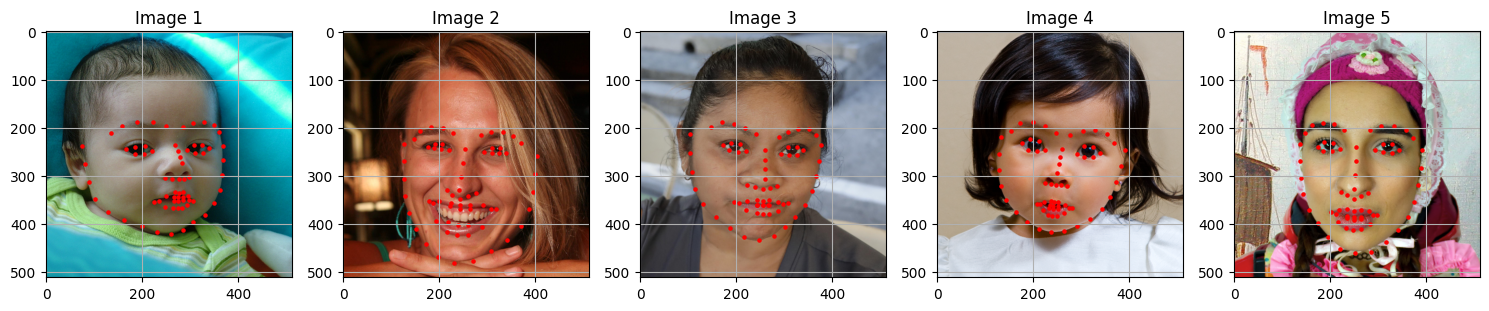

In [ ]:
# Наложим точки на изображение
num_images_to_display = 5

plt.figure(figsize=(15, 10))

for i in range(min(num_images_to_display, len(image_files), len(orig_annotations))):
    image_filename = image_files[i]
    image_path = os.path.join(IMAGES_DIR, image_filename)

    group_key = str(i)

    if group_key in orig_annotations:
        group_data = orig_annotations[group_key]
        face_landmarks = group_data.get('face_landmarks')

        if face_landmarks and group_data.get('file_name') == image_filename:
            try:
                img = Image.open(image_path)
                plt.subplot(1, num_images_to_display, i + 1)
                plt.imshow(img)
                plt.title(f"Image {i+1}")
                # plt.axis('off')  # Отключаем оси
                plt.grid() # Сетка

                x_coords = [point[0] for point in face_landmarks]
                y_coords = [point[1] for point in face_landmarks]
                plt.scatter(x_coords, y_coords, color='red', s=5)  # Накладываем точки на изображение

            except Exception as e:
                print(f"Ошибка при обработке изображения {image_filename}: {e}")

        else:
            print(f"Предупреждение: Отсутствуют 'face_landmarks' или имя файла не совпадает для группы {i+1} (file: {image_filename}, data: {group_data.get('file_name')})")
    else:
        print(f"Предупреждение: Group {i+1} отсутствует в данных JSON.")

plt.tight_layout()
plt.show()

In [ ]:
# Кол-во точек 68, следовательно координат точек 68*2=136
key_pts = []
files = []

for value in orig_annotations.values():
    face_landmarks = value['face_landmarks']
    face_landmarks = np.array(face_landmarks).reshape(-1)
    key_pts.append(face_landmarks)
    file_name = value["file_name"]
    files.append(file_name)

key_pts = np.array(key_pts)

key_pts.shape

(5000, 136)

In [ ]:
all_keys = list(orig_annotations.keys())
len(all_keys)

5000

Видим, что точки накладываются на изображение правильно. Всего у нас 5000 изображений и 68 точек на каждом изображении.

## Разделим данные на тренировочные и валидационные

In [ ]:
train_keys, val_keys = train_test_split(
    all_keys, test_size=0.2, random_state=SEED
)

In [ ]:
train_annotations = {
    orig_annotations[k]["file_name"]: orig_annotations[k]["face_landmarks"]
    for k in train_keys
}
val_annotations = {
    orig_annotations[k]["file_name"]: orig_annotations[k]["face_landmarks"]
    for k in val_keys
}

print(f"Train samples: {len(train_annotations)}")
print(f"Val samples:   {len(val_annotations)}")

Train samples: 4000
Val samples:   1000


Получили 4000 тренировочных изображения с точками и 1000 валидационных.

## Аугментация тренировочных изображений

Далее я сделаю аугментацию для изображений, так как я изначально прогнал данные на исходных изображениях и модель получилась не очень хорошей, особенно на видео, где лицо находится в движении и часто не только смотрит в камеру, но и вращается по вертикали, меняет положение. Поэтому принято решение увеличить обучающие данные и выполнить следующие аугментации:

- *HorizontalFlip* (отражение по горизонтали),
- *Affine* (деформация),
- *RandomBrightnessContrast* (изменение контраста)

In [ ]:
# Подготовка директории
os.makedirs(AUG_IMAGES_DIR, exist_ok=True)

In [ ]:
# Используем Albumentations для аугментации с метками
aug_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(translate_percent=0.05, rotate=(-15, 15), scale=(0.9, 1.1), shear=5, p=0.7),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


In [ ]:
# Создаем папку с оригинальными изображениями + аугментированные (только для обучающей выборки)

aug_annotations = {}
success_count = 0
skipped_count = 0
num_augments = 3

for img_name, kps in tqdm(train_annotations.items(), desc="Augmenting train images"):
    orig_path = os.path.join(IMAGES_DIR, img_name)
    if not os.path.exists(orig_path):
        print(f"Image not found: {orig_path}")
        skipped_count += 1
        continue

    try:
        image = np.array(Image.open(orig_path).convert("RGB"))
        keypoints_np = np.array(kps, dtype=np.float32)
        if keypoints_np.ndim != 2 or keypoints_np.shape[1] != 2:
            print(f"Skipping {img_name}: invalid keypoints shape {keypoints_np.shape}")
            skipped_count += 1
            continue
        keypoints_tuples = [tuple(pt) for pt in keypoints_np]
    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        skipped_count += 1
        continue

    # Сохраняем оригинал
    shutil.copy2(orig_path, os.path.join(AUG_IMAGES_DIR, img_name))
    aug_annotations[img_name] = [list(map(float, pt)) for pt in keypoints_tuples]

    # Создаём N аугментированных копий
    for i in range(num_augments):
        try:
            augmented = aug_pipeline(image=image, keypoints=keypoints_tuples)
            aug_image = augmented["image"]
            aug_kps = augmented["keypoints"]
            aug_name = img_name.replace(".png", f"_aug{i+1}.png")
            save_path = os.path.join(AUG_IMAGES_DIR, aug_name)
            Image.fromarray(aug_image).save(save_path)
            aug_annotations[aug_name] = [list(map(float, pt)) for pt in aug_kps]
            success_count += 1
        except Exception as e:
            print(f"Augmentation error for {img_name}: {e}")
            skipped_count += 1

print(f"\nFinished augmentation.")
print(f"Original train images processed: {len(train_annotations)}")
print(f"Total augmented samples added:   {success_count}")
print(f"Skipped due to errors:           {skipped_count}")

#  Сохраняем JSON
os.makedirs(os.path.dirname(AUG_JSON_FILE), exist_ok=True)
with open(AUG_JSON_FILE, 'w') as f:
    json.dump(aug_annotations, f)

with open(VAL_JSON_FILE, 'w') as f:
    json.dump(val_annotations, f)

print(f"Saved: {AUG_JSON_FILE} ({len(aug_annotations)} samples) and {VAL_JSON_FILE} ({len(val_annotations)} samples)")

Augmenting train images: 100%|██████████| 4000/4000 [13:41<00:00,  4.87it/s]



Finished augmentation.
Original train images processed: 4000
Total augmented samples added:   12000
Skipped due to errors:           0
Saved: content\augmented_content\all_data_aug.json (16000 samples) and content\augmented_content\val.json (1000 samples)


В итоге мы получили 12000 аугментированных изображений + 4000 исходных изображений для тренировки. Для валидации мы ничего не делали, оставили все те же 1000 изображений.

In [ ]:
def visualize_augmented_set(base_filename, images_dir=AUG_IMAGES_DIR, annotations_file=AUG_JSON_FILE):
    """
    Показывает оригинальное изображение и 3 его аугментированных версии с наложенными ключевыми точками.
    Пример: base_filename = '00000.png'
    """
    if not os.path.exists(annotations_file):
        print(f"JSON файл не найден: {annotations_file}")
        return

    with open(annotations_file, 'r') as f:
        annotations = json.load(f)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    filenames = [base_filename] + [base_filename.replace('.png', f'_aug{i+1}.png') for i in range(3)]

    for idx, fname in enumerate(filenames):
        img_path = os.path.join(images_dir, fname)
        axs[idx].set_title(fname)
        axs[idx].axis('off')

        if not os.path.exists(img_path):
            axs[idx].text(0.5, 0.5, f"Missing\n{fname}", fontsize=10, ha='center', va='center')
            continue

        image = Image.open(img_path)
        axs[idx].imshow(image)

        kps = annotations.get(fname, [])
        if isinstance(kps, list) and len(kps) > 0:
            try:
                kps = np.array(kps, dtype=np.float32)
                if kps.ndim == 2 and kps.shape[1] == 2:
                    axs[idx].scatter(kps[:, 0], kps[:, 1], s=10, c='red')
            except Exception as e:
                print(f"Ошибка при визуализации {fname}: {e}")

    plt.tight_layout()
    plt.show()

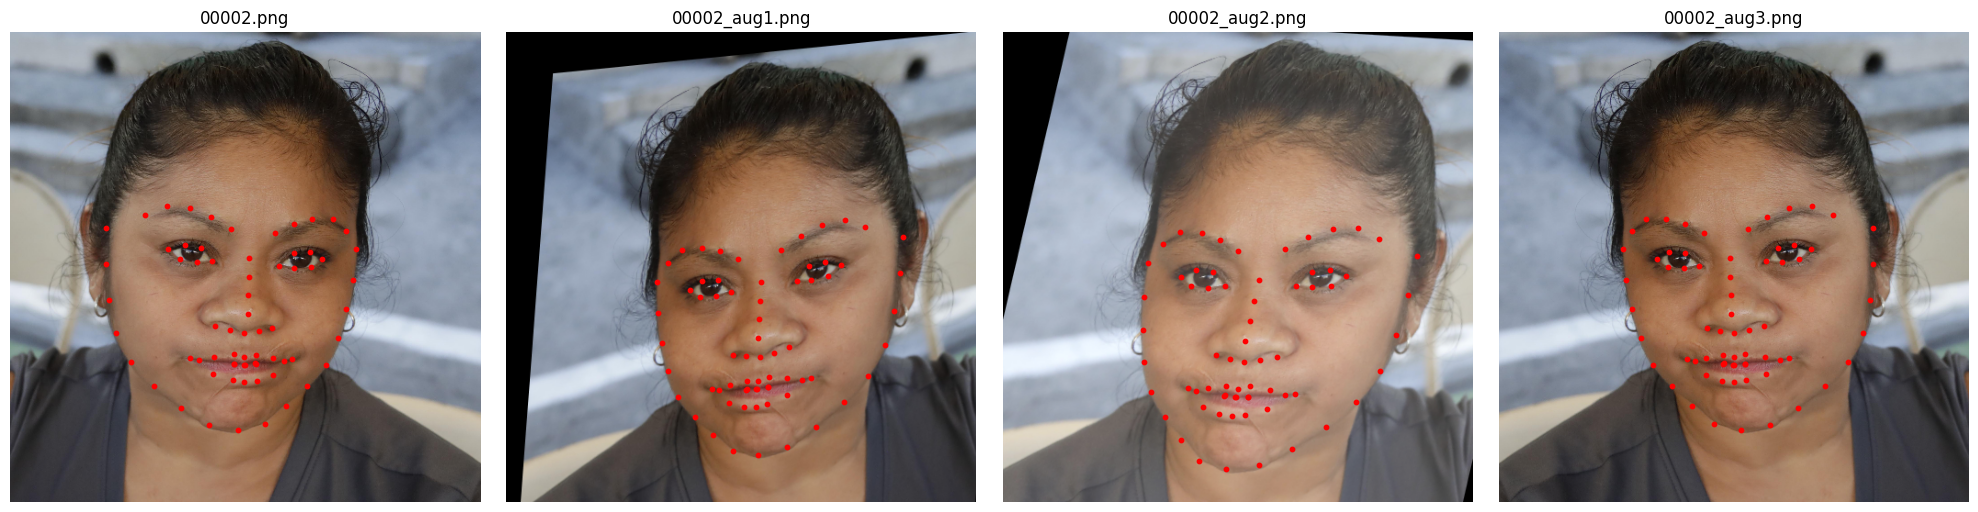

In [ ]:
visualize_augmented_set("00002.png")

Благодаря библиотеки *Albumentations* все точки после применения аугментаций также изменили свои координаты.

In [ ]:
# архивируем папку augment_content чтобы потом скачать ее с Colab
# !zip -r /content/augmented_content.zip /content/augmented_content

In [ ]:
# # скачаем локально аугметированные изображения, чтобы они не пропали в Colab после смены среды
# from google.colab import files
# files.download("/content/augmented_content.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Создание датасетов для обучения и валидации

In [ ]:
# Создание датасета
def make_dataset(images_dir, json_file, transform=None):
    class FacialKeypointsJSONDataset(Dataset):
        def __init__(self, images_dir, json_file, transform=None):

            # Путь к папке с изображениями
            self.images_dir = images_dir

            # Загружаем аннотации из JSON-файла (словарь: имя_файла → список keypoints)
            with open(json_file, 'r') as f:
                self.annotations = json.load(f)

            # Сохраняем список всех имён изображений
            self.image_names = list(self.annotations.keys())
            # Трансформации, которые будем применять к изображениям
            self.transform = transform

        def __len__(self):
            # Количество изображений в датасете
            return len(self.image_names)

        def __getitem__(self, idx):
            # Загружаем изображение и его ключевые точки по индексу
            img_name = self.image_names[idx]
            img_path = os.path.join(self.images_dir, img_name)

            # Открываем изображение и конвертируем в RGB
            image = Image.open(img_path).convert("RGB")
            # Загружаем ключевые точки из аннотаций и приводим к numpy float32
            keypoints = np.array(self.annotations[img_name], dtype=np.float32)

            # Вычисляем ограничивающую рамку (bounding box) вокруг всех ключевых точек
            # Коробка вокруг всех keypoints + margin
            x_min, y_min = keypoints.min(axis=0)
            x_max, y_max = keypoints.max(axis=0)

            # Добавляем небольшой отступ по всем сторонам рамки
            m = 10
            x_min, y_min = max(0, x_min-m), max(0, y_min-m)
            x_max = min(image.width,  x_max+m)
            y_max = min(image.height, y_max+m)


            # Преобразуем координаты рамки в формат тензора
            boxes  = torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32)
            # Метка класса (все объекты одного класса — лица - label=1)
            labels = torch.ones((1,), dtype=torch.int64)

            # Преобразуем ключевые точки к формату [1, num_points, 3]
            # Последнее измерение: [x, y, visibility]
            kp = np.zeros((1, keypoints.shape[0], 3), dtype=np.float32)
            kp[0, :, :2] = keypoints
            kp[0, :, 2]  = 2  # # Все точки видимые (visibility=2)

            # Словарь target, соответствующий формату, который ожидает KeypointRCNN
            target = {
                "boxes":        boxes, # Рамка вокруг лица
                "labels":       labels, # Метка класса
                "keypoints":    torch.from_numpy(kp), # Ключевые точки
                "image_id":     torch.tensor([idx]), # ID изображения
                "area":         torch.tensor([(x_max-x_min)*(y_max-y_min)], dtype=torch.float32), # Площадь рамки
                "iscrowd":      torch.zeros((1,), dtype=torch.int64)
            }
            # Применяем преобразования к изображению
            if self.transform:
                image = self.transform(image)

            return image, target
    # Возвращаем объект датасета
    return FacialKeypointsJSONDataset(images_dir, json_file, transform)

Создаем тренировочный и валидационный датасеты для подачи их в DataLoader и использовании в обучении модели. Для обучения используем 16000 изображений (аугментации+оригинальные), для валидации 1000 изображений (только оригинальные).

In [ ]:
train_dataset = make_dataset(AUG_IMAGES_DIR, AUG_JSON_FILE, transform=T.ToTensor())
val_dataset   = make_dataset(IMAGES_DIR, VAL_JSON_FILE, transform=T.ToTensor())

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

## Дообучение модели

Далее мы дообучаем модель `keypointrcnn_resnet50_fpn` с весами `KeypointRCNN_ResNet50_FPN_Weights`. Изначально *KeypointRCNNPredictor* слой в модели предсказывает 17 точек на лице, нам же необходимо предсказывать 68 точек. Для этого мы заменим последний выходной слой модели на необходимый нам, то есть укажем явно, что хотим, чтобы модель предсказывала *num_keypoints=68*.

In [ ]:
# Используем либо GPU, либо CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Загружаем предобученную модель
weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
model = keypointrcnn_resnet50_fpn(weights=weights, num_classes=2)

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to C:\Users\nizae/.cache\torch\hub\checkpoints\keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:21<00:00, 11.2MB/s] 


In [ ]:
model

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [ ]:
# Заменяем keypoint head на 68 точек
in_channels = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(in_channels, num_keypoints=68)
model.to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [ ]:
# Используем Оптимизатор и scheduler
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Функция обучения
def train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=10,
    best_model_path=BEST_MODEL_PATH
):
    best_val_rmse = float('inf')
    best_epoch = -1

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        # Train phase
        model.train()
        running_loss = 0.0
        for images, targets in tqdm(train_loader, desc="Training"):  # batch of 4
            imgs = [img.to(device) for img in images]
            tars = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(imgs, tars)
            loss = sum(loss for loss in loss_dict.values())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        scheduler.step()
        print(f"Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        total_rmse = 0.0
        count = 0
        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc="Validation"):
                imgs = [img.to(device) for img in images]
                preds = model(imgs)
                for pred, target in zip(preds, targets):
                    pred_pts = pred['keypoints'][0].cpu().numpy()[:, :2]
                    true_pts = target['keypoints'][0].cpu().numpy()[:, :2]
                    mse = mean_squared_error(true_pts, pred_pts)
                    total_rmse += np.sqrt(mse)
                    count += 1

        avg_val_rmse = total_rmse / count if count > 0 else float('inf')
        print(f"Val RMSE: {avg_val_rmse:.4f}")

        if avg_val_rmse < best_val_rmse:
            best_val_rmse = avg_val_rmse
            best_epoch = epoch
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch} (RMSE: {best_val_rmse:.4f})")

    print(f"\nTraining complete. Best Val RMSE: {best_val_rmse:.4f} at epoch {best_epoch}")

**В данном цикле на валидации мы выбрали метрику RMSE**

`mse = mean_squared_error(true_pts, pred_pts)` - вычисляет MSE для текущего примера (используя *sklearn.metrics.mean_squared_error* — усреднение по всем точкам и обеим координатам).

`np.sqrt(mse)` берёт из этого значение квадратный корень, т. е. RMSE для изображения.

`total_rmse += ...` аккумулирует RMSE по всем примерам в валидационном датасете.

**Итоговая метрика**

В конце мы делим сумму всех RMSE на число примеров:

`avg_val_rmse = total_rmse / count` и получаем средний RMSE по всем изображениям, который показывает, насколько в среднем каждая ключевая точка «плохо» предсказывается в пикселях.

In [ ]:
# Запускаем обучение
train_and_validate(num_epochs=20)


Epoch 1/20


Training: 100%|██████████| 4000/4000 [53:43<00:00,  1.24it/s] 


Train Loss: 2.6644


Validation: 100%|██████████| 250/250 [01:08<00:00,  3.65it/s]


Val RMSE: 34.1349
Saved best model at epoch 1 (RMSE: 34.1349)

Epoch 2/20


Training: 100%|██████████| 4000/4000 [52:02<00:00,  1.28it/s]


Train Loss: 2.3439


Validation: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]


Val RMSE: 16.2426
Saved best model at epoch 2 (RMSE: 16.2426)

Epoch 3/20


Training: 100%|██████████| 4000/4000 [50:31<00:00,  1.32it/s]


Train Loss: 2.1721


Validation: 100%|██████████| 250/250 [01:09<00:00,  3.58it/s]


Val RMSE: 43.3184

Epoch 4/20


Training: 100%|██████████| 4000/4000 [49:42<00:00,  1.34it/s]


Train Loss: 2.0397


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.74it/s]


Val RMSE: 13.7873
Saved best model at epoch 4 (RMSE: 13.7873)

Epoch 5/20


Training: 100%|██████████| 4000/4000 [47:54<00:00,  1.39it/s]


Train Loss: 1.9211


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.75it/s]


Val RMSE: 23.0740

Epoch 6/20


Training: 100%|██████████| 4000/4000 [48:08<00:00,  1.38it/s]


Train Loss: 1.4739


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.78it/s]


Val RMSE: 19.0193

Epoch 7/20


Training: 100%|██████████| 4000/4000 [48:13<00:00,  1.38it/s]


Train Loss: 1.3400


Validation: 100%|██████████| 250/250 [01:07<00:00,  3.73it/s]


Val RMSE: 23.3834

Epoch 8/20


Training: 100%|██████████| 4000/4000 [48:01<00:00,  1.39it/s]


Train Loss: 1.2720


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.73it/s]


Val RMSE: 17.6736

Epoch 9/20


Training: 100%|██████████| 4000/4000 [48:05<00:00,  1.39it/s]


Train Loss: 1.2223


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.76it/s]


Val RMSE: 21.6859

Epoch 10/20


Training: 100%|██████████| 4000/4000 [48:05<00:00,  1.39it/s]


Train Loss: 1.1811


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.76it/s]


Val RMSE: 28.4377

Epoch 11/20


Training: 100%|██████████| 4000/4000 [48:03<00:00,  1.39it/s]


Train Loss: 1.1317


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.76it/s]


Val RMSE: 22.8907

Epoch 12/20


Training: 100%|██████████| 4000/4000 [48:04<00:00,  1.39it/s]


Train Loss: 1.1231


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.73it/s]


Val RMSE: 21.9835

Epoch 13/20


Training: 100%|██████████| 4000/4000 [48:06<00:00,  1.39it/s]


Train Loss: 1.1164


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.73it/s]


Val RMSE: 22.5827

Epoch 14/20


Training: 100%|██████████| 4000/4000 [48:11<00:00,  1.38it/s]


Train Loss: 1.1130


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.77it/s]


Val RMSE: 21.9871

Epoch 15/20


Training: 100%|██████████| 4000/4000 [48:14<00:00,  1.38it/s]


Train Loss: 1.1075


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.74it/s]


Val RMSE: 21.3694

Epoch 16/20


Training: 100%|██████████| 4000/4000 [48:09<00:00,  1.38it/s]


Train Loss: 1.1007


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.74it/s]


Val RMSE: 21.9450

Epoch 17/20


Training: 100%|██████████| 4000/4000 [48:07<00:00,  1.39it/s]


Train Loss: 1.1004


Validation: 100%|██████████| 250/250 [01:07<00:00,  3.73it/s]


Val RMSE: 22.2438

Epoch 18/20


Training: 100%|██████████| 4000/4000 [48:06<00:00,  1.39it/s]


Train Loss: 1.0985


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.73it/s]


Val RMSE: 21.9864

Epoch 19/20


Training: 100%|██████████| 4000/4000 [48:06<00:00,  1.39it/s]


Train Loss: 1.1003


Validation: 100%|██████████| 250/250 [01:06<00:00,  3.77it/s]


Val RMSE: 22.1713

Epoch 20/20


Training: 100%|██████████| 4000/4000 [48:07<00:00,  1.39it/s]


Train Loss: 1.0973


Validation: 100%|██████████| 250/250 [01:07<00:00,  3.69it/s]

Val RMSE: 22.1910

Training complete. Best Val RMSE: 13.7873 at epoch 4


Не смотря на 20 эпох обучения (обучение длилось 998 минут или более 16.5 часов) лучшая метрика RMSE была получена уже на 4 эпохе. Именно эти веса после 4 эпохи и были выбраны для дальнейшей работы. Они записаны на диск под названием `best_keypoint_rcnn.pt`

In [ ]:
def visualize_keypoint_rcnn_predictions(
    model,
    dataset,
    device,
    num_images=5,
    score_thresh=0.5,
    alpha_gt=0.5,
    alpha_pred=0.5,
    point_size=20
):
    """
    Визуализация предсказаний KeypointRCNN vs Ground Truth.

    Параметры:
    - model       : обученная KeypointRCNN в режиме eval.
    - dataset     : Dataset, возвращающий (image_tensor, target_dict).
    - device      : torch.device.
    - num_images  : число примеров для вывода.
    - score_thresh: порог confidence, выше которого рисуем предсказания.
    - alpha_gt    : прозрачность точек GT.
    - alpha_pred  : прозрачность точек предсказаний.
    - point_size  : размер точек.
    """
    model.eval()
    fig = plt.figure(figsize=(4 * num_images, 4))

    # Легенда-патчи
    gt_patch   = mpatches.Patch(color='blue', label='Ground Truth')
    pred_patch = mpatches.Patch(color='red',  label='Predicted')

    for i in range(num_images):
        image_tensor, target = dataset[i]
        image = image_tensor.to(device)

        with torch.no_grad():
            prediction = model([image])[0]

        # Подготовка изображения
        img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        cmap = 'gray' if img_np.ndim == 2 or img_np.shape[2] == 1 else None
        if cmap == 'gray':
            img_np = img_np.squeeze()

        # Извлечение GT
        gt_kpts_full = target['keypoints'][0].cpu().numpy()  # (68,3)
        gt_vis       = gt_kpts_full[:, 2].astype(bool)
        gt_kpts      = gt_kpts_full[:, :2]

        # Извлечение предсказаний
        scores = prediction['scores'].cpu().numpy()
        if len(scores) > 0 and scores[0] > score_thresh:
            pred_kpts = prediction['keypoints'][0].cpu().numpy()[:, :2]
        else:
            pred_kpts = None

        # Рисуем
        ax = fig.add_subplot(1, num_images, i + 1)
        ax.imshow(img_np, cmap=cmap)
        ax.set_title(f"Sample #{i+1}")
        ax.axis('off')

        # GT точки
        ax.scatter(
            gt_kpts[gt_vis, 0], gt_kpts[gt_vis, 1],
            c='blue', s=point_size, alpha=alpha_gt
        )

        # Predicted точки
        if pred_kpts is not None:
            ax.scatter(
                pred_kpts[:, 0], pred_kpts[:, 1],
                c='red', s=point_size, alpha=alpha_pred
            )

        # Легенда только на первом subplot
        if i == 0:
            ax.legend(handles=[gt_patch, pred_patch], loc='lower right')

    plt.suptitle("KeypointRCNN: Ground Truth (blue) vs Predicted (red)", fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

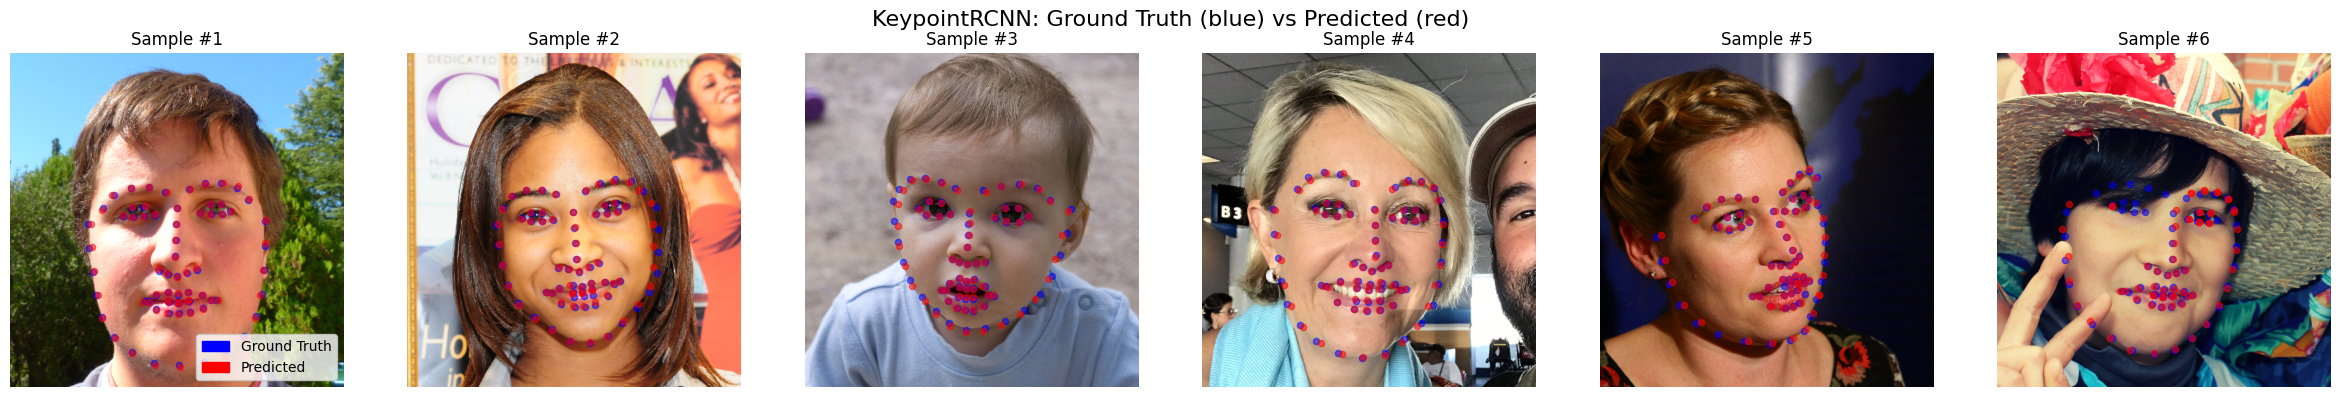

In [ ]:
visualize_keypoint_rcnn_predictions(model, val_dataset, device=device, num_images=6, score_thresh=0.5)

Видим что модель с лучшими весами довольно неплохо предсказывает положение точек на лице. Единственное, судя по последней картинке, места, где части лица чем то закрыты, модель пропускает. Это тоже можно решить, добавив аугментацию *Случайное стирание (Erasing)* или *RandomCrop*, которая позволяет вырезать из изображения часть определённого размера. Пока оставим все как есть и посмотрим как справится модель с инференсом.

## Проверка модели на инференсе

### Инференс на видео

Чтобы использовать нашу модель на видео, необходимо сначала детектировать лицо или несколько лиц, и затем на каждом найденном лице отрисовать точки. Для детекции лиц будем использовать `MTCNN` - это модель для обнаружения лиц в библиотеке FaceNet-PyTorch.

Также, для корректного сохранения и вывода предсказанного видео в браузере или в ячейке ноутбука добавлена функция, которая определяет есть ли звук на видео. Если он есть, то видео возвращается со своим оригинальным звуком. Если нет, то добавляется пустая аудиодорожка. Это небольшой "костыль", необходимый для корректного отображения видео без звука в ячейке или браузере.

In [ ]:
def has_audio_stream(video_path):
    """Проверяет наличие аудиодорожки в видеофайле с помощью ffprobe"""
    try:
        result = subprocess.run(
            ["ffprobe", "-loglevel", "error",
             "-select_streams", "a",
             "-show_entries", "stream=codec_type",
             "-of", "csv=p=0", video_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        return 'audio' in result.stdout
    except Exception:
        return False  # если ffprobe не сработал, считаем что аудио нет

def predict_video_mtcnn(
    video_path, # путь к входному видеофайлу
    model, # модель Keypoint RCNN
    device, # устройство (cuda или cpu)
    save_path=None, # путь для сохранения результирующего видео (опционально)
    score_thresh=0.7, # порог уверенности предсказания keypoint-детектора
    show=True # флаг, нужно ли показывать результат прямо в ноутбуке
):
    """
    Инференс по видео с детекцией лиц через MTCNN + KeypointRCNN.
    Добавляет пустую аудиодорожку при отсутствии звука,
    или копирует оригинальную при наличии.
    """
    # Проверка существования входного видео
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")

    # Уникальное имя, если не указано явно
    if save_path is None:
        save_path = f"pred_{uuid4().hex[:8]}.mp4"

    # Инициализация детектора лиц MTCNN
    mtcnn = MTCNN(keep_all=True, device=device)

    # Открытие видео для чтения (чтобы получить свойства)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError("Failed to open video")

    # Получаем общее количество кадров, FPS, ширину и высоту кадра
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    # Создание директории, если она ещё не существует
    os.makedirs(Path(save_path).parent, exist_ok=True)

    # Временный путь для «сырых» кадров без перекодировки
    raw_path = save_path.replace(".mp4", "_raw.mp4")

    # Создание объекта для записи видео (используем mp4v-кодек)
    writer = cv2.VideoWriter(
        raw_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (W, H)
    )

    # Прогресс-бар по кадрам
    pbar = tqdm(total=total_frames, desc="Processing video", unit="frame")
    model.eval()

        # Без вычисления градиентов
    with torch.no_grad():
        cap = cv2.VideoCapture(video_path)
        while True:
            ret, frame = cap.read()
            if not ret:
                break # выход из цикла при окончании видео

            # Перевод BGR → RGB для корректной работы моделей
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Детекция лиц с помощью MTCNN
            boxes_mtcnn, _ = mtcnn.detect(frame)

            # Подготовка обрезанных регионов лиц
            crops = []
            if boxes_mtcnn is not None and len(boxes_mtcnn) > 0:
                for (x1, y1, x2, y2) in boxes_mtcnn.astype(int):
                    # Расширение области вокруг лица
                    w = x2 - x1
                    pad = int(0.4 * w)
                    xa, ya = max(0, x1 - pad), max(0, y1 - pad)
                    xb, yb = min(W, x2 + pad), min(H, y2 + pad)
                    crops.append((xa, ya, xb, yb))
            else:
                crops = [(0, 0, W, H)] # Если лиц не найдено, анализируем весь кадр

            # Обработка каждого crop’а (одного или нескольких)
            for (xa, ya, xb, yb) in crops:
                face_crop = rgb[ya:yb, xa:xb] # вырезаем лицо из кадра
                pil = Image.fromarray(face_crop) # конвертируем в PIL
                tensor = T.ToTensor()(pil).to(device) # превращаем в тензор PyTorch
                out = model([tensor])[0] # Предсказание keypoints через модель

                # Извлекаем bounding box, keypoints и оценки
                boxes = out["boxes"].cpu().numpy()
                kps = out["keypoints"].cpu().numpy()
                scores = out["scores"].cpu().numpy()
                keep = scores > score_thresh # отфильтровываем слабые предсказания

                # Отрисовка результатов на кадре
                for box, kp in zip(boxes[keep], kps[keep]):
                    bx1, by1, bx2, by2 = box.astype(int)
                    bx1 += xa; bx2 += xa; by1 += ya; by2 += ya # коррекция координат
                    cv2.rectangle(frame, (bx1, by1), (bx2, by2), (0, 255, 0), 2)
                    for px, py, v in kp:
                        if v > 0:
                            # Отрисовка точки, если видимость > 0
                            cv2.circle(frame, (int(px)+xa, int(py)+ya), 5, (0, 0, 255), -1)

            # Сохраняем обработанный кадр
            writer.write(frame)
            pbar.update(1)

        # Закрываем ресурсы
        cap.release()
        writer.release()
        pbar.close()

    # Проверка наличия звука
    has_audio = has_audio_stream(video_path)

    final_path = save_path
    if has_audio:
        # Команда для копирования оригинальной аудиодорожки
        cmd = [
            "ffmpeg", "-y",
            "-i", raw_path,
            "-i", video_path,
            "-c:v", "libx264",
            "-pix_fmt", "yuv420p",
            "-c:a", "aac",
            "-map", "0:v:0",  # видео из raw_path
            "-map", "1:a:0",  # аудио из оригинального файла
            "-shortest",
            "-movflags", "+faststart",
            final_path
        ]
    else:
        # Добавление пустой аудиодорожки
        cmd = [
            "ffmpeg", "-y",
            "-i", raw_path,
            "-f", "lavfi", "-i", "anullsrc=channel_layout=stereo:sample_rate=44100", # генерация пустого звука
            "-c:v", "libx264", # перекодировка видео в x264
            "-pix_fmt", "yuv420p", # совместимый пиксельный формат
            "-preset", "fast", # быстрая компрессия
            "-c:a", "aac", # аудиокодек AAC
            "-shortest", # обрезать по длине видео
            "-movflags", "+faststart", # переместить moov atom в начало (для браузеров)
            final_path
        ]

    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Удаляем временный файл
    os.remove(raw_path)

    # Выводим плеер в ячейку ноутбука
    if show:
        display(IPVideo(final_path, embed=True, width=min(640, W)))

    return final_path

In [ ]:
predict_video_mtcnn(
    video_path="example_3.mp4",
    model=model,
    device=device,
    save_path="predict/example_3_pred_mtcnn.mp4",
    score_thresh=0.7,
    show=True
)

![Пример вывода видео](11111.JPG)

Видим, что на видео точки детектятся очень хорошо. Есть огрехи на лицах с бородой, возможно в обучающих данных не было или было мало лиц с бородой. Также видны лишние боксы в случаях, когда лица соприкасаются и имеют общие точки.

### Инференс на картинке

In [ ]:
# Инициализируем MTCNN (keep_all=True для множественной детекции)
mtcnn = MTCNN(keep_all=True, device=device)

def predict_image_with_mtcnn(
    img_path: str,
    model: torch.nn.Module,
    device: torch.device,
    save_path: str = "pred.png",
    score_thresh: float = 0.7,
    show: bool = True,
    pad_factor: float = 0.2
):
    """
    Детектим лица через MTCNN, затем для каждого кропа делаем KeypointRCNN инференс.

    - img_path     : путь к изображению
    - model        : обученная KeypointRCNN в режиме eval
    - device       : torch.device
    - save_path    : куда сохранять результат
    - score_thresh : порог уверенности для keypoints
    - show         : показывать результат в ноутбуке
    - pad_factor   : доля расширения бокса вокруг лица (0.2 = +20%)
    """
    # 1) Загружаем и проверяем
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise RuntimeError(f"Failed to load image: {img_path}")
    H, W = bgr.shape[:2]
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # 2) MTCNN детекция
    boxes, _ = mtcnn.detect(rgb)
    crops = []
    if boxes is not None and len(boxes) > 0:
        for (x1, y1, x2, y2) in boxes.astype(int):
            w, h = x2 - x1, y2 - y1
            pad_w = int(pad_factor * w)
            pad_h = int(pad_factor * h)
            xa = max(0, x1 - pad_w)
            ya = max(0, y1 - pad_h)
            xb = min(W, x2 + pad_w)
            yb = min(H, y2 + pad_h)
            crops.append((xa, ya, xb, yb))
    else:
        # Если MTCNN не нашёл лиц — обрабатываем всё изображение
        crops = [(0, 0, W, H)]

    # 3) Для каждого crop — инференс KeypointRCNN
    for (xa, ya, xb, yb) in crops:
        face = rgb[ya:yb, xa:xb]
        pil = Image.fromarray(face)
        tensor = T.ToTensor()(pil).to(device)
        with torch.no_grad():
            out = model([tensor])[0]

        boxes_k, kps, scores = (
            out["boxes"].cpu().numpy(),
            out["keypoints"].cpu().numpy(),
            out["scores"].cpu().numpy()
        )
        keep = scores > score_thresh

        for box, kp in zip(boxes_k[keep], kps[keep]):
            bx1, by1, bx2, by2 = box.astype(int)
            # смещаем обратно
            bx1 += xa; bx2 += xa
            by1 += ya; by2 += ya
            cv2.rectangle(bgr, (bx1, by1), (bx2, by2), (0,255,0), 2)
            for px, py, v in kp:
                if v > 0:
                    cv2.circle(
                        bgr,
                        (int(px) + xa, int(py) + ya),
                        3, (0,0,255), -1
                    )

    # 4) Показ и сохранение
    if show:
        plt.figure(figsize=(8,8))
        plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Prediction: {os.path.basename(img_path)}")
        plt.show()

    cv2.imwrite(save_path, bgr)
    print(f"Saved prediction to {save_path}")

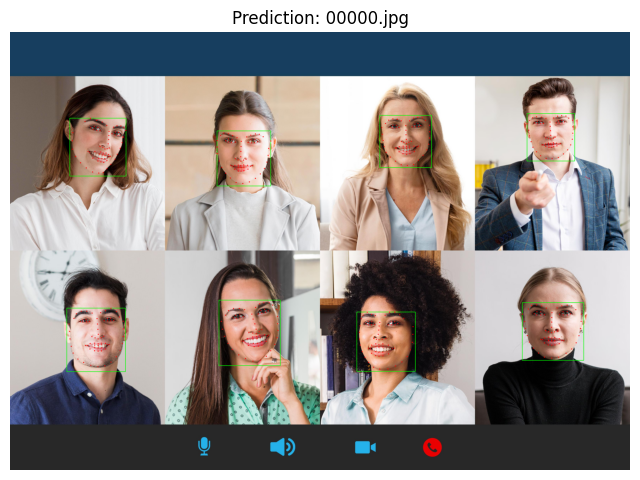

Saved prediction to predict/00000_pred_mtcnn.png


In [ ]:
predict_image_with_mtcnn(
    "00000.jpg",
    model,
    device,
    save_path="predict/00000_pred_mtcnn.png",
    score_thresh=0.9,
    show=True,
    pad_factor=0.2      # расширить боксы на pad_factor %
)

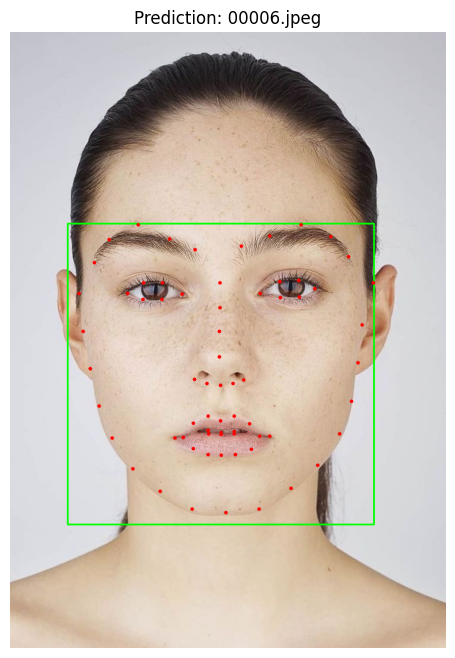

Saved prediction to predict/00006_pred_mtcnn.png


In [ ]:
predict_image_with_mtcnn(
    "00006.jpeg",
    model,
    device,
    save_path="predict/00006_pred_mtcnn.png",
    score_thresh=0.9,
    show=True,
    pad_factor=0.3  # расширить боксы на pad_factor %
)

На картинках, будь то одно лицо или несколько, модель отрабатывает отлично. Принцип работы тот же, что и на видео - детектируем лицо с помощью MTCNN, предсказываем точки, отрисовываем.

## Приложение на Gradio

Для запуска приложения в Google Colab ячейке в переменных средах должны находится следующие файлы:

- `best_keypoint_rcnn.pt` - файл с весами лучшей модели
- `example_3.mp4` - пример видео
- `00000.jpg` - пример картинки

Также необходимо установить библиотеки:

*!pip install gradio*

*!pip install facenet_pytorch* (если не установили в самом начале ноутбука)

In [ ]:
import os
import cv2
import torch
import torchvision.transforms as T
from PIL import Image
from facenet_pytorch import MTCNN
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
import gradio as gr
import subprocess
import uuid
import threading

# Загрузка модели

def load_model(weights_path: str, device: torch.device):
    weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
    model = keypointrcnn_resnet50_fpn(weights=weights, num_classes=2)
    in_channels = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
    model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(in_channels, num_keypoints=68)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device).eval()
    return model

# Проверка наличия звука в видео

def has_audio_stream(video_path):
    try:
        result = subprocess.run(
            ["ffprobe", "-loglevel", "error",
             "-select_streams", "a",
             "-show_entries", "stream=codec_type",
             "-of", "csv=p=0", video_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        return 'audio' in result.stdout
    except Exception:
        return False

# Инференс для изображения

def predict_image(img, score_thresh=0.9, pad_factor=0.2, return_bgr=False):
    H, W = img.shape[:2]
    bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    boxes, _ = mtcnn.detect(Image.fromarray(img))
    crops = []
    if boxes is not None and len(boxes) > 0:
        for (x1, y1, x2, y2) in boxes.astype(int):
            w, h = x2 - x1, y2 - y1
            pad_w, pad_h = int(pad_factor * w), int(pad_factor * h)
            xa, ya = max(0, x1 - pad_w), max(0, y1 - pad_h)
            xb, yb = min(W, x2 + pad_w), min(H, y2 + pad_h)
            crops.append((xa, ya, xb, yb))
    else:
        crops = [(0, 0, W, H)]

    draw = bgr.copy()
    with torch.no_grad():
        for xa, ya, xb, yb in crops:
            crop = bgr[ya:yb, xa:xb]
            tensor = T.ToTensor()(Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))).to(DEVICE)
            out = MODEL([tensor])[0]
            boxes_k = out['boxes'].detach().cpu().numpy()
            kps = out['keypoints'].detach().cpu().numpy()
            scores = out['scores'].detach().cpu().numpy()
            for box, kp, s in zip(boxes_k, kps, scores):
                if s > score_thresh:
                    bx1, by1, bx2, by2 = box.astype(int)
                    bx1 += xa; bx2 += xa; by1 += ya; by2 += ya
                    cv2.rectangle(draw, (bx1, by1), (bx2, by2), (0,255,0), 2)
                    for px, py, v in kp:
                        if v > 0:
                            cv2.circle(draw, (int(px)+xa, int(py)+ya), 4, (0,0,255), -1)
    if return_bgr:
        return draw
    else:
        rgb_out = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        cv2.imwrite('keypoint_image.png', draw)
        return rgb_out, 'keypoint_image.png'

# Инференс для видео

def predict_video(path, score_thresh=0.7, pad_factor=0.4):
    temp = f"temp_{uuid.uuid4().hex}.mp4"
    final = f"keypoint_video_{uuid.uuid4().hex}.mp4"
    cap = cv2.VideoCapture(path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)); H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(temp, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H))
    while True:
        ret, frame = cap.read()
        if not ret: break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        bgr = predict_image(rgb, score_thresh, pad_factor, return_bgr=True)
        writer.write(bgr)
    cap.release(); writer.release()

    has_audio = has_audio_stream(path)

    if has_audio:
        cmd = [
            'ffmpeg', '-y',
            '-i', temp, '-i', path,
            '-c:v', 'libx264', '-pix_fmt', 'yuv420p',
            '-c:a', 'aac',
            '-map', '0:v:0', '-map', '1:a:0',
            '-shortest', '-movflags', '+faststart', final
        ]
    else:
        cmd = [
            'ffmpeg', '-y',
            '-i', temp,
            '-f', 'lavfi', '-i', 'anullsrc=channel_layout=stereo:sample_rate=44100',
            '-c:v', 'libx264', '-pix_fmt', 'yuv420p', '-c:a', 'aac',
            '-shortest', '-movflags', '+faststart', final
        ]

    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    os.remove(temp)
    return final, final

# Реалтайм обработка видео с камеры (OpenCV + PyTorch)

def realtime_webcam_inference(conf_threshold=0.7, pad_factor=0.2):
    global webcam_running
    webcam_running = True
    cap = cv2.VideoCapture(0)
    while webcam_running:
        ret, frame = cap.read()
        if not ret:
            break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = predict_image(rgb, conf_threshold, pad_factor, return_bgr=True)
        cv2.imshow("Keypoints", result)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


def stop_webcam():
    global webcam_running
    webcam_running = False

# Инициализируем девайс и модель
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL = load_model('best_keypoint_rcnn.pt', DEVICE)
mtcnn = MTCNN(keep_all=True, device=DEVICE)

# Gradio App

def build_app():
    css = """
    .gradio-container {max-width: 70% !important; margin: auto;}
    .upload-box {max-width: 100% !important; margin: auto;}
    .upload-box img {max-width: 50% !important; height: auto !important; margin: auto;}
    .preview-box img {max-width: 50% !important; height: auto !important; margin: auto;}
    .upload-box video {max-width: 50% !important; height: auto !important; margin: auto;}
    .preview-box video {max-width: 50% !important; height: auto !important; margin: auto;}
"""
    with gr.Blocks(css=css) as demo:
        gr.Markdown('# Facial Keypoint Detection')
        with gr.TabItem('Image'):
            inp = gr.Image(type='numpy', label='Upload Image', elem_classes='upload-box')
            sc = gr.Slider(label="Score Threshold", minimum=0.0, maximum=1.0, step=0.05, value=0.9)
            pd = gr.Slider(label="Padding Factor", minimum=0.0, maximum=0.8, step=0.05, value=0.2)
            out = gr.Image(type='numpy', label='Preview', elem_classes='preview-box')
            dl = gr.File(label='Download Result')
            ex = gr.Examples(
                examples=['00000.jpg'],
                inputs=[inp],
                label='Example Images'
            )
            run = gr.Button('Run')
            clear = gr.Button('Clear')
            run.click(fn=predict_image, inputs=[inp, sc, pd], outputs=[out, dl], show_progress=True)
            clear.click(fn=lambda: (None,None,None), inputs=[], outputs=[inp, out, dl])
        with gr.TabItem('Video'):
            vin = gr.Video(label='Upload Video', elem_classes='upload-box')
            s2 = gr.Slider(label="Score Threshold", minimum=0.0, maximum=1.0, step=0.05, value=0.7)
            p2 = gr.Slider(label="Padding Factor", minimum=0.0, maximum=0.8, step=0.05, value=0.4)
            vout = gr.Video(label='Preview Video', elem_classes='preview-box')
            vdl = gr.File(label='Download Result')
            ex2 = gr.Examples(
                examples=['example_3.mp4'],
                inputs=[vin],
                label='Example Videos'
            )
            run2 = gr.Button('Run')
            clear2 = gr.Button('Clear')
            run2.click(fn=predict_video, inputs=[vin, s2, p2], outputs=[vout, vdl], show_progress=True)
            clear2.click(fn=lambda: (None,None,None), inputs=[], outputs=[vin, vout, vdl])
        with gr.TabItem('Webcam'):
            s3 = gr.Slider(label="Score Threshold", minimum=0.0, maximum=1.0, step=0.05, value=0.9)
            p3 = gr.Slider(label="Padding Factor", minimum=0.0, maximum=0.8, step=0.05, value=0.5)
            start = gr.Button("Start Webcam Inference")
            stop = gr.Button("Stop Webcam")
            start.click(fn=lambda s, p: threading.Thread(target=realtime_webcam_inference, args=(s, p)).start(), inputs=[s3, p3], outputs=[])
            stop.click(fn=stop_webcam, inputs=[], outputs=[])
    return demo

if __name__ == '__main__':
    app = build_app()
    app.launch(server_name='0.0.0.0', server_port=7860, share=True)


## Деплой приложения на Hugging Face

На платформе Hugging Face было выгружено приложение [Facial Keypoint Detection](https://huggingface.co/spaces/NizaevEdgar/Face_Keypoint_Detection).

Но из-за того, что бесплатно можно использовать только CPU, приложение очень медленно обрабатывает видео файлы и поток видео с веб-камеры.

Приложение выложено исключительно для демонстрации интерфейса.

### Пример файла README

# 🧠 Facial Keypoint Detection with Keypoint R-CNN

Gradio-приложение для детекции лицевых ключевых точек (68 точек) на изображениях, видео и в реальном времени с веб-камеры.  
Модель основана на архитектуре `Keypoint R-CNN` с предобученными весами и дообучена на кастомном датасете.

---

## 🚀 Возможности

- 📸 Загрузка изображений с детекцией ключевых точек
- 🎥 Загрузка видеофайлов с детекцией ключевых точек
- 🎦 Реалтайм обработка с веб-камеры
- 🎯 Регулируемые порог уверенности (*Score Threshold*) и степень обрезки (*Padding Factor*)
- 💾 Скачивание обработанных изображений и видео

---

## 🧠 Используемые технологии

- `Gradio` для пользовательского интерфейса
- `PyTorch` + `Torchvision` — для инференса модели `Keypoint R-CNN`
- `facenet-pytorch` (MTCNN) — для предварительной локализации лица
- `OpenCV` — для обработки изображений и видео
- `FFmpeg` — для обработки аудиопотока и объединения с видео

---

## 🖼️ Пример использования

1. Загрузите изображение или видео
2. Настройте параметры:
   - `Score Threshold`: минимальный порог уверенности модели
   - `Padding Factor`: дополнительная область вокруг лица
3. Нажмите **Run**
4. Скачайте результат или просмотрите в интерфейсе
5. При необходимости очистите вкладку кнопкой **Clear**

---